In [11]:
# Load environment variables and set up auto-reload
from dotenv import load_dotenv
load_dotenv()

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Google-styled docstring
A Google-style docstring is one of the most popular conventions for writing Python docstrings (documentation inside """ ... """).

It was popularized by Google’s Python style guide, and many tools (like Sphinx, pydocstyle, and LangChain’s @tool(parse_docstring=True)) know how to parse it.
Example:

```python
def add_numbers(x: int, y: int) -> int:
    """Add two numbers together.

    Args:
        x (int): The first number.
        y (int): The second number.

    Returns:
        int: The sum of x and y.

    Raises:
        ValueError: If x or y are not valid numbers.
    """
    return x + y
```

In [12]:
from rich.console import Console
from rich.panel import Panel
from rich.text import Text
import json
console = Console()

def show_prompt(prompt_text: str, title: str = "Prompt", border_style: str = "blue"):
    """
    Display a prompt with rich formatting and XML tag highlighting.
    
    Args:
        prompt_text: The prompt string to display
        title: Title for the panel (default: "Prompt")
        border_style: Border color style (default: "blue")
    """
    # Create a formatted display of the prompt
    formatted_text = Text(prompt_text)
    formatted_text.highlight_regex(r'<[^>]+>', style="bold blue")  # Highlight XML tags
    formatted_text.highlight_regex(r'##[^#\n]+', style="bold magenta")  # Highlight headers
    formatted_text.highlight_regex(r'###[^#\n]+', style="bold cyan")  # Highlight sub-headers

    # Display in a panel for better presentation
    console.print(Panel(
        formatted_text, 
        title=f"[bold green]{title}[/bold green]",
        border_style=border_style,
        padding=(1, 2)
    ))

In [13]:
from prompts import research_agent_prompt
show_prompt(research_agent_prompt, "Research Agent Instructions")

╭────────────────────────────────────────── Research Agent Instructions ──────────────────────────────────────────╮
│                                                                                                                 │
│  You are a research assistant conducting research on the user's input topic. For context, today's date is       │
│  {date}.                                                                                                        │
│                                                                                                                 │
│  <Task>                                                                                                         │
│  Your job is to use tools to gather information about the user's input topic.                                   │
│  You can use any of the tools provided to you to find resources that can help answer the research question.     │
│  You can call these tools in series or in parallel, your research is conducted in a tool-calling loop.          │
│  </Task>                                                                                                        │
│                                                                                                                 │
│  <Available Tools>                                                                                              │
│  You have access to two main tools:                                                                             │
│  1. **tavily_search**: For conducting web searches to gather information                                        │
│  2. **think_tool**: For reflection and strategic planning during research                                       │
│                                                                                                                 │
│  **CRITICAL: Use think_tool after each search to reflect on results and plan next steps**                       │
│  </Available Tools>                                                                                             │
│                                                                                                                 │
│  <Instructions>                                                                                                 │
│  Think like a human researcher with limited time. Follow these steps:                                           │
│                                                                                                                 │
│  1. **Read the question carefully** - What specific information does the user need?                             │
│  2. **Start with broader searches** - Use broad, comprehensive queries first                                    │
│  3. **After each search, pause and assess** - Do I have enough to answer? What's still missing?                 │
│  4. **Execute narrower searches as you gather information** - Fill in the gaps                                  │
│  5. **Stop when you can answer confidently** - Don't keep searching for perfection                              │
│  </Instructions>                                                                                                │
│                                                                                                                 │
│  <Hard Limits>                                                                                                  │
│  **Tool Call Budgets** (Prevent excessive searching):                                                           │
│  - **Simple queries**: Use 2-3 search tool calls maximum                                                        │
│  - **Complex queries**: Use up to 5 search tool calls maximum                                                   │
│  - **Always stop**: After 5 search tool calls if you cannot find the right sources                              │
│                                                       

In [14]:
# %%writefile ../src/deep_research_from_scratch/state_research.py

"""
State Definitions and Pydantic Schemas for Research Agent

This module defines the state objects and structured schemas used for
the research agent workflow, including researcher state management and output schemas.
"""

import operator
from typing_extensions import TypedDict, Annotated, List, Sequence
from pydantic import BaseModel, Field
from langchain_core.messages import BaseMessage
from langgraph.graph.message import add_messages

# ===== STATE DEFINITIONS ===== All these states are needed for making the 
#                               model produce structured output

class ResearcherState(TypedDict):
    """
    State for the research agent containing message history and research metadata.
    
    This state tracks the researcher's conversation, iteration count for limiting
    tool calls, the research topic being investigated, compressed findings,
    and raw research notes for detailed analysis.
    """
    researcher_messages: Annotated[Sequence[BaseMessage], add_messages]
    tool_call_iterations: int
    research_topic: str
    compressed_research: str
    raw_notes: Annotated[List[str], operator.add]

class ResearcherOutputState(TypedDict):
    """
    Output state for the research agent containing final research results.
    
    This represents the final output of the research process with compressed
    research findings and all raw notes from the research process.
    """
    compressed_research: str
    raw_notes: Annotated[List[str], operator.add]
    researcher_messages: Annotated[Sequence[BaseMessage], add_messages]

# ===== STRUCTURED OUTPUT SCHEMAS =====

class ClarifyWithUser(BaseModel):
    """Schema for user clarification decisions during scoping phase."""
    need_clarification: bool = Field(
        description="Whether the user needs to be asked a clarifying question.",
    )
    question: str = Field(
        description="A question to ask the user to clarify the report scope",
    )
    verification: str = Field(
        description="Verify message that we will start research after the user has provided the necessary information.",
    )

class ResearchQuestion(BaseModel):
    """Schema for research brief generation."""
    research_brief: str = Field(
        description="A research question that will be used to guide the research.",
    )

class Summary(BaseModel):
    """Schema for webpage content summarization."""
    summary: str = Field(description="Concise summary of the webpage content")
    key_excerpts: str = Field(description="Important quotes and excerpts from the content")

In [15]:
"""LangChain provides the @tool decorator to turn a normal Python function into 
a LangChain tool.

It has metadata like:
name (defaults to function name)
description (from docstring) Docstring are descriptions below the function name
args_schema (from type hints or Pydantic model, if provided)
"""

# %%writefile ../src/deep_research_from_scratch/utils.py

"""Research Utilities and Tools.

This module provides search and content processing utilities for the research agent,
including web search capabilities and content summarization tools.
"""

from pathlib import Path
from datetime import datetime
from typing_extensions import Annotated, List, Literal

from langchain.chat_models import init_chat_model 
from langchain_core.messages import HumanMessage
from langchain_core.runnables import RunnableConfig
from langchain_core.tools import tool, InjectedToolArg
from tavily import TavilyClient

# from deep_research_from_scratch.state_research import Summary
# from deep_research_from_scratch.prompts import summarize_webpage_prompt
from prompts import summarize_webpage_prompt

# ===== UTILITY FUNCTIONS =====

def get_today_str() -> str:
    """Get current date in a human-readable format.
    Passing current date to the prompt makes the llm know if its outside the
    knowledge cutoff date, hence, it can search for more recent information
    and donot hallucinate."""
    return datetime.now().strftime("%a %b %-d, %Y")

def get_current_dir() -> Path:
    """Get the current directory of the module.

    This function is compatible with Jupyter notebooks and regular Python scripts.

    Returns:
        Path object representing the current directory
    """
    try:
        return Path(__file__).resolve().parent
    except NameError:  # __file__ is not defined
        return Path.cwd()

# ===== CONFIGURATION =====

summarization_model = init_chat_model(model="gpt-4o-mini")
tavily_client = TavilyClient()

# ===== SEARCH FUNCTIONS =====

def tavily_search_multiple(
    search_queries: List[str], 
    max_results: int = 3, 
    topic: Literal["general", "news", "finance"] = "general", 
    include_raw_content: bool = True, 
) -> List[dict]:
    """Perform search using Tavily API for multiple queries.

    Args:
        search_queries: List of search queries to execute
        max_results: Maximum number of results per query
        topic: Topic filter for search results
        include_raw_content: Whether to include raw webpage content

    Returns:
        List of search result dictionaries
    """
    
    # Execute searches sequentially. Note: yon can use AsyncTavilyClient to parallelize this step.
    search_docs = []
    for query in search_queries:
        result = tavily_client.search(
            query,
            max_results=max_results,
            include_raw_content=include_raw_content,
            topic=topic
        )
        search_docs.append(result)

    return search_docs

def summarize_webpage_content(webpage_content: str) -> str:
    """Summarize webpage content using the configured summarization model.
    
    Args:
        webpage_content: Raw webpage content to summarize
        
    Returns:
        Formatted summary with key excerpts
    """
    try:
        # Set up structured output model for summarization
        structured_model = summarization_model.with_structured_output(Summary)
        
        # Generate summary
        summary = structured_model.invoke([
            HumanMessage(content=summarize_webpage_prompt.format(
                webpage_content=webpage_content, 
                date=get_today_str()
            ))
        ])
        
        # Format summary with clear structure
        formatted_summary = (
            f"<summary>\n{summary.summary}\n</summary>\n\n"
            f"<key_excerpts>\n{summary.key_excerpts}\n</key_excerpts>"
        )
        
        return formatted_summary
        
    except Exception as e:
        print(f"Failed to summarize webpage: {str(e)}")
        return webpage_content[:1000] + "..." if len(webpage_content) > 1000 else webpage_content

def deduplicate_search_results(search_results: List[dict]) -> dict:
    """Deduplicate search results by URL to avoid processing duplicate content.
    
    Args:
        search_results: List of search result dictionaries
        
    Returns:
        Dictionary mapping URLs to unique results
    """
    unique_results = {}
    
    for response in search_results:
        for result in response['results']:
            url = result['url']
            if url not in unique_results:
                unique_results[url] = result
    
    return unique_results

def process_search_results(unique_results: dict) -> dict:
    """Process search results by summarizing content where available.
    
    Args:
        unique_results: Dictionary of unique search results
        
    Returns:
        Dictionary of processed results with summaries
    """
    summarized_results = {}
    """
    Tavily search sometimes returns summary and sometimes the full raw content.
    Thats why we are doing result.get("raw_content") and not result["raw_content"].
    """
    for url, result in unique_results.items():
        # Use existing content if no raw content for summarization
        if not result.get("raw_content"):
            """
            Both result.get("raw_content") and result["raw_content"] are ways 
            to access dictionary keys, but they behave differently when the key 
            doesn't exist.
            Raises KeyError if "raw_content" is missing in result["raw_content"]
            and returns None in result.get("raw_content").
            We can also use a default value with result.get("raw_content", "").
            """
            content = result['content']
        else:
            # Summarize raw content for better processing
            content = summarize_webpage_content(result['raw_content'])
        
        summarized_results[url] = {
            'title': result['title'],
            'content': content
        }
    
    return summarized_results

def format_search_output(summarized_results: dict) -> str:
    """Format search results into a well-structured string output.
    
    Args:
        summarized_results: Dictionary of processed search results
        
    Returns:
        Formatted string of search results with clear source separation
    """
    if not summarized_results:
        return "No valid search results found. Please try different search queries or use a different search API."
    
    formatted_output = "Search results: \n\n"
    
    for i, (url, result) in enumerate(summarized_results.items(), 1):
        formatted_output += f"\n\n--- SOURCE {i}: {result['title']} ---\n"
        formatted_output += f"URL: {url}\n\n"
        formatted_output += f"SUMMARY:\n{result['content']}\n\n"
        formatted_output += "-" * 80 + "\n"
    
    return formatted_output

# ===== RESEARCH TOOLS =====

@tool(parse_docstring=True)
def tavily_search(
    query: str,
    max_results: Annotated[int, InjectedToolArg] = 3,
    topic: Annotated[Literal["general", "news", "finance"], InjectedToolArg] = "general",
) -> str:
    """Fetch results from Tavily search API with content summarization.

    Args:
        query: A single search query to execute
        max_results: Maximum number of results to return
        topic: Topic to filter results by ('general', 'news', 'finance')

    Returns:
        Formatted string of search results with summaries
    """
    # Execute search for single query
    search_results = tavily_search_multiple(
        [query],  # Convert single query to list for the internal function
        max_results=max_results,
        topic=topic,
        include_raw_content=True,
    )

    # Deduplicate results by URL to avoid processing duplicate content
    unique_results = deduplicate_search_results(search_results)

    # Process results with summarization
    summarized_results = process_search_results(unique_results)

    # Format output for consumption
    return format_search_output(summarized_results)

@tool(parse_docstring=True)
def think_tool(reflection: str) -> str:
    """Tool for strategic reflection on research progress and decision-making.
    
    Use this tool after each search to analyze results and plan next steps systematically.
    This creates a deliberate pause in the research workflow for quality decision-making.
    
    When to use:
    - After receiving search results: What key information did I find?
    - Before deciding next steps: Do I have enough to answer comprehensively?
    - When assessing research gaps: What specific information am I still missing?
    - Before concluding research: Can I provide a complete answer now?
    
    Reflection should address:
    1. Analysis of current findings - What concrete information have I gathered?
    2. Gap assessment - What crucial information is still missing?
    3. Quality evaluation - Do I have sufficient evidence/examples for a good answer?
    4. Strategic decision - Should I continue searching or provide my answer?
    
    Returns: 
        Confirmation that reflection was recorded for decision-making
    
    Args: 
        reflection: Your detailed reflection on research progress, findings, gaps, and next steps.
        
    """
    return f"Reflection recorded: {reflection}"

In [ ]:
# %%writefile ../src/deep_research_from_scratch/research_agent.py

"""Research Agent Implementation.

This module implements a research agent that can perform iterative web searches
and synthesis to answer complex research questions.
"""

from pydantic import BaseModel, Field
from typing_extensions import Literal

from langgraph.graph import StateGraph, START, END
from langchain_core.messages import SystemMessage, HumanMessage, ToolMessage, filter_messages
from langchain.chat_models import init_chat_model

# from deep_research_from_scratch.state_research import ResearcherState, ResearcherOutputState
# from deep_research_from_scratch.utils import tavily_search, get_today_str, think_tool
from prompts import research_agent_prompt, compress_research_system_prompt, compress_research_human_message

# ===== CONFIGURATION =====

# Set up tools and model binding
tools = [tavily_search, think_tool]
tools_by_name = {tool.name: tool for tool in tools}

# Initialize models
# model = init_chat_model(model="anthropic:claude-sonnet-4-20250514")
model = init_chat_model(model="gpt-4o-mini")
model_with_tools = model.bind_tools(tools)
"""
Binding the model with tools
If you do the above then the output of this call (AIMessage) can include tool_calls.
which can be fetched by tool_calls = state["researcher_messages"][-1].tool_calls
so tool_calls is a dictionary like this
[
  {
    "name": "tavily_search",
    "args": {"query": "latest AI research papers", "max_results": 5}
  }
] along with other keys like "id"
"""
summarization_model = init_chat_model(model="gpt-4o-mini")
compress_model = init_chat_model(model="gpt-4o-mini", max_tokens=16000) # model="anthropic:claude-sonnet-4-20250514", max_tokens=64000
# gpt-4o-mini has approx 16k output tokens
# ===== AGENT NODES =====

def llm_call(state: ResearcherState):
    """Analyze current state and decide on next actions.
    
    The model analyzes the current conversation state and decides whether to:
    1. Call search tools to gather more information
    2. Provide a final answer based on gathered information
    
    Returns updated state with the model's response.
    """
    return {
        "researcher_messages": [
            model_with_tools.invoke(
                [SystemMessage(content=research_agent_prompt)] + state["researcher_messages"]
            )
        ]
    }

def tool_node(state: ResearcherState):
    """Execute all tool calls from the previous LLM response.
    
    Executes all tool calls from the previous LLM responses.
    Returns updated state with tool execution results.
    """
    tool_calls = state["researcher_messages"][-1].tool_calls
 
    # Execute all tool calls
    observations = []
    for tool_call in tool_calls:
        tool = tools_by_name[tool_call["name"]]
        observations.append(tool.invoke(tool_call["args"]))
            
    # Create tool message outputs
    tool_outputs = [
        ToolMessage( # Create a tool message for each observation
            content=observation,
            name=tool_call["name"],
            tool_call_id=tool_call["id"]
        ) for observation, tool_call in zip(observations, tool_calls)
    ]
    
    return {"researcher_messages": tool_outputs}

def compress_research(state: ResearcherState) -> dict:
    """Compress research findings into a concise summary.
    
    Takes all the research messages and tool outputs and creates
    a compressed summary suitable for the supervisor's decision-making.
    """
    
    system_message = compress_research_system_prompt.format(date=get_today_str())
    messages = [SystemMessage(content=system_message)] + state.get("researcher_messages", []) + [HumanMessage(content=compress_research_human_message)]
    response = compress_model.invoke(messages)
    
    # Extract raw notes from tool and AI messages
    """
    filter_messages filters messages by type. for example from a convo you just 
    want tool and ai message it does that.
    """
    raw_notes = [
        str(m.content) for m in filter_messages(
            state["researcher_messages"], 
            include_types=["tool", "ai"]
        )
    ]
    
    return {
        "compressed_research": str(response.content),
        "raw_notes": ["\n".join(raw_notes)]
    }

# ===== ROUTING LOGIC =====

def should_continue(state: ResearcherState) -> Literal["tool_node", "compress_research"]:
    """Determine whether to continue research or provide final answer.
    
    Determines whether the agent should continue the research loop or provide
    a final answer based on whether the LLM made tool calls.
    
    Returns:
        "tool_node": Continue to tool execution
        "compress_research": Stop and compress research
    """
    messages = state["researcher_messages"]
    last_message = messages[-1]
    
    # If the LLM makes a tool call, continue to tool execution
    if last_message.tool_calls:
        return "tool_node"
    # Otherwise, we have a final answer
    return "compress_research"

# ===== GRAPH CONSTRUCTION =====

# Build the agent workflow
agent_builder = StateGraph(ResearcherState, output_schema=ResearcherOutputState)

# Add nodes to the graph
agent_builder.add_node("llm_call", llm_call)
agent_builder.add_node("tool_node", tool_node)
agent_builder.add_node("compress_research", compress_research)

# Add edges to connect nodes
agent_builder.add_edge(START, "llm_call")
agent_builder.add_conditional_edges(
    "llm_call", # from node
    should_continue, # function to determine next node
    { # next nodes
        "tool_node": "tool_node", # Continue research loop
        "compress_research": "compress_research", # Provide final answer
    },
)
agent_builder.add_edge("tool_node", "llm_call") # Loop back for more research
agent_builder.add_edge("compress_research", END)

# Compile the agent
researcher_agent = agent_builder.compile()

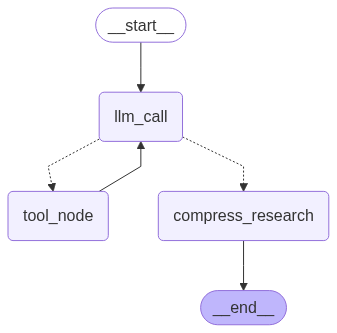

In [17]:
from IPython.display import Image, display
# from deep_research_from_scratch.research_agent import researcher_agent

# Show the agent
display(Image(researcher_agent.get_graph(xray=True).draw_mermaid_png()))

In [18]:
# Run the agent
from utils import format_messages
from langchain_core.messages import HumanMessage

# Example brief
# research_brief = """I want to identify and evaluate the coffee shops in San Francisco that are considered the best based specifically  
# on coffee quality. My research should focus on analyzing and comparing coffee shops within the San Francisco area, 
# using coffee quality as the primary criterion. I am open regarding methods of assessing coffee quality (e.g.,      
# expert reviews, customer ratings, specialty coffee certifications), and there are no constraints on ambiance,      
# location, wifi, or food options unless they directly impact perceived coffee quality. Please prioritize primary    
# sources such as the official websites of coffee shops, reputable third-party coffee review organizations (like     
# Coffee Review or Specialty Coffee Association), and prominent review aggregators like Google or Yelp where direct  
# customer feedback about coffee quality can be found. The study should result in a well-supported list or ranking of
# the top coffee shops in San Francisco, emphasizing their coffee quality according to the latest available data as  
# of July 2025."""
research_brief = """I want to know about the NLP conferences happening in 2025. Dont research too much. 
Just want a brief overview"""

result = researcher_agent.invoke({"researcher_messages": [HumanMessage(content=f"{research_brief}.")]})
format_messages(result['researcher_messages'])

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ I want to know about the NLP conferences happening in 2025. Dont research too much.                             │
│ Just want a brief overview.                                                                                     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: tavily_search                                                                                     │
│    Args: {                                                                                                      │
│   "query": "NLP conferences 2025 schedule"                                                                      │
│ }                                                                                                               │
│    ID: call_Khw7zjMwNTzz9RQlkfSjLKGf                                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Search results:                                                                                                 │
│                                                                                                                 │
│                                                                                                                 │
│                                                                                                                 │
│ --- SOURCE 1: NLP Call For Papers for Conferences, Workshops ... ---                                            │
│ URL: http://www.wikicfp.com/cfp/call?conference=NLP                                                             │
│                                                                                                                 │
│ SUMMARY:                                                                                                        │
│ <summary>                                                                                                       │
│ The webpage from WikiCFP highlights various Calls for Papers (CFPs) related to Natural Language Processing      │
│ (NLP) events, including conferences, workshops, and journals. Key upcoming events include the TSD 2025          │
│ conference in Erlangen, Germany (Aug 25-28, 2025) and the *SEM 2025 conference in Suzhou, China (Nov 5-9,       │
│ 2025). The deadline for submissions for most events is May 30 and May 31, 2025. The homepage provides resources │
│ for users to log in, register, and post CFPs. An overview of the NLP events includes detailed deadlines and     │
│ locations for each conference, along with links to the CFP details.                                             │
│ </summary>                                                                                                      │
│                                                                                                                 │
│ <key_excerpts>                                                                                                  │
│ Total of 2334 CFPs in 117 pages, TSD 2025: Aug 25-28, 2025, Erlangen, Germany, *SEM 2025: Nov 5-9, 2025,        │
│ Suzhou, China, Most deadlines are May 30 and May 31, 2025.                                                      │
│ </key_excerpts>                                                                                                 │
│                                                                                                                 │
│ --------------------------------------------------------------------------------                                │
│                                                                                                                 │
│                                                                                                                 │
│ --- SOURCE 2: Events List | ACL Member Portal ---                                                               │
│ URL: https://www.aclweb.org/portal/events?order=field_event_date&sort=desc                                      │
│                                                                                                                 │
│ SUMMARY:                                                                                                        │
│ <summary>                                                                                                       │
│ The webpage lists upcoming events related to computational linguistics organized by the Association for         │
│ Computational Linguistics (ACL). Key events include:                                                            │
│ - 'UniDive training school on diversity in NLP' in Yerevan, Armenia (January 20-24, 2026), with a submission    │
│ deadline of June 2, 2025.                              

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: think_tool                                                                                        │
│    Args: {                                                                                                      │
│   "reflection": "I found a couple of significant NLP conferences scheduled for 2025. Notably, the TSD 2025 will │
│ take place in Erlangen, Germany from August 25-28, and the *SEM 2025 will be held in Suzhou, China from         │
│ November 5-9. Additionally, there are workshops associated with these conferences, including the Third Workshop │
│ on AI for Scientific Publications on December 23, 2025, in Mumbai, India. However, I still need to check for    │
│ any additional events or specific focus areas of these conferences or others that may be happening in 2025."    │
│ }                                                                                                               │
│    ID: call_wGSwGnPFrHGLNzR0x59v81Vb                                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Reflection recorded: I found a couple of significant NLP conferences scheduled for 2025. Notably, the TSD 2025  │
│ will take place in Erlangen, Germany from August 25-28, and the *SEM 2025 will be held in Suzhou, China from    │
│ November 5-9. Additionally, there are workshops associated with these conferences, including the Third Workshop │
│ on AI for Scientific Publications on December 23, 2025, in Mumbai, India. However, I still need to check for    │
│ any additional events or specific focus areas of these conferences or others that may be happening in 2025.     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: tavily_search                                                                                     │
│    Args: {                                                                                                      │
│   "query": "Natural Language Processing conferences 2025 overview"                                              │
│ }                                                                                                               │
│    ID: call_dDRR2cKF2rf4koOoUWiGGQvw                                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Search results:                                                                                                 │
│                                                                                                                 │
│                                                                                                                 │
│                                                                                                                 │
│ --- SOURCE 1: 8th International Conference on Natural Language ---                                              │
│ URL: https://www.icnlsp.org/2025welcome/                                                                        │
│                                                                                                                 │
│ SUMMARY:                                                                                                        │
│ <summary>                                                                                                       │
│ The 8th International Conference on Natural Language and Speech Processing (ICNLSP 2025) is scheduled to take   │
│ place from August 25 to 27, 2025, at the University of Southern Denmark in Odense. This hybrid conference aims  │
│ to foster collaboration among researchers, academics, and industry professionals in advancing the fields of     │
│ Natural Language Processing (NLP) and Speech Processing. The event includes a call for papers on a wide array   │
│ of topics in both NLP and speech processing, with a double-blind review process for submissions. Keynote        │
│ speakers include distinguished researchers such as Prof. Dr. Barbara Plank, Prof. Dr. Anders Søgaard, and Prof. │
│ Peter Schneider-Kamp. Important dates include a paper submission deadline of June 8, 2025, and notification of  │
│ acceptance by July 20, 2025. Accepted papers will be published in the ACL Anthology, and the conference will    │
│ feature social events including receptions at the University and in the city. Participants can expect to engage │
│ with the latest findings and trends in the domain, as well as opportunities for networking and discussion.      │
│ </summary>                                                                                                      │
│                                                                                                                 │
│ <key_excerpts>                                                                                                  │
│ ICNLSP 2025 provides a dynamic platform for researchers, academics, students, and industry professionals to     │
│ share insights, exchange ideas, and stay up to date with the latest advancements in NLP and Speech Processing.  │
│ The conference will feature regular sessions, along with keynote talks delivered by distinguished international │
│ researchers. All accepted papers will be published in ACL Anthology.                                            │
│ </key_excerpts>                                                                                                 │
│                                                                                                                 │
│ --------------------------------------------------------------------------------                                │
│                                                                                                                 │
│                                                                                                                 │
│ --- SOURCE 2: The 2025 Conference on Empirical Methods in Natural ... ---                                       │
│ URL: https://linguistlist.org/issues/36/640/                                                                    │
│                                                        

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: think_tool                                                                                        │
│    Args: {                                                                                                      │
│   "reflection": "I found several notable NLP conferences scheduled for 2025. In addition to TSD 2025 and *SEM   │
│ 2025, which I previously mentioned, the 8th International Conference on Natural Language and Speech Processing  │
│ (ICNLSP 2025) will occur from August 25-27 in Odense, Denmark. Keynote speakers include well-regarded           │
│ researchers, and papers accepted will be published in the ACL Anthology. Furthermore, the Conference on         │
│ Empirical Methods in Natural Language Processing (EMNLP 2025) is set for November 5-9 in Suzhou, China,         │
│ focusing on empirical research in NLP and emphasizing interdisciplinary impacts. Overall, I've identified key   │
│ events with varying themes and deadlines. I think I have sufficient information to provide a brief overview of  │
│ the NLP conferences in 2025."                                                                                   │
│ }                                                                                                               │
│    ID: call_PvaL806zeVpPRnySuUEOgwf6                                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Reflection recorded: I found several notable NLP conferences scheduled for 2025. In addition to TSD 2025 and    │
│ *SEM 2025, which I previously mentioned, the 8th International Conference on Natural Language and Speech        │
│ Processing (ICNLSP 2025) will occur from August 25-27 in Odense, Denmark. Keynote speakers include              │
│ well-regarded researchers, and papers accepted will be published in the ACL Anthology. Furthermore, the         │
│ Conference on Empirical Methods in Natural Language Processing (EMNLP 2025) is set for November 5-9 in Suzhou,  │
│ China, focusing on empirical research in NLP and emphasizing interdisciplinary impacts. Overall, I've           │
│ identified key events with varying themes and deadlines. I think I have sufficient information to provide a     │
│ brief overview of the NLP conferences in 2025.                                                                  │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Here’s a brief overview of notable NLP conferences scheduled for 2025:                                          │
│                                                                                                                 │
│ 1. **TSD 2025 (International Conference on Text, Speech, and Dialogue)**                                        │
│    - **Date:** August 25-28, 2025                                                                               │
│    - **Location:** Erlangen, Germany                                                                            │
│    - **Focus:** This conference covers a wide range of topics related to natural language processing, speech    │
│ recognition, and dialogue systems.                                                                              │
│                                                                                                                 │
│ 2. **ICNLSP 2025 (8th International Conference on Natural Language and Speech Processing)**                     │
│    - **Date:** August 25-27, 2025                                                                               │
│    - **Location:** Odense, Denmark                                                                              │
│    - **Details:** It's a hybrid conference aimed at fostering collaboration among researchers and industry      │
│ professionals. Accepted papers will be published in the ACL Anthology.                                          │
│                                                                                                                 │
│ 3. **EMNLP 2025 (Conference on Empirical Methods in Natural Language Processing)**                              │
│    - **Date:** November 5-9, 2025                                                                               │
│    - **Location:** Suzhou, China                                                                                │
│    - **Focus:** This year's theme emphasizes interdisciplinary impacts of NLP advancements. The conference will │
│ include tracks for original research papers on various topics, such as safety in large language models.         │
│                                                                                                                 │
│ 4. ***SEM 2025 (Semantic Evaluation Conference)**                                                               │
│    - **Date:** November 5-9, 2025                                                                               │
│    - **Location:** Suzhou, China                                                                                │
│    - **Focus:** This conference deals specifically with the semantic aspects of NLP, exploring model            │
│ evaluations and the impact of semantics in NLP applications.                                                    │
│                                                                                                                 │
│ These conferences represent significant opportunities for academic and industry professionals to share          │
│ insights, network, and discuss advancements in natural language processing.                                     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

In [20]:
from rich.markdown import Markdown
Markdown(result['compressed_research'])

List of Queries and Tool Calls Made                                                                                
Searches on NLP conferences scheduled for 2025, including both general overviews and specific calls for papers.    

Fully Comprehensive Findings                                                                                       

 1 TSD 2025 (International Conference on Text, Speech, and Dialogue)                                               
    • Date: August 25-28, 2025                                                                                     
    • Location: Erlangen, Germany                                                                                  
    • Details: This conference is dedicated to topics related to natural language processing, speech recognition,  
      and dialogue systems. The call for papers indicates important submission deadlines of May 30 and May 31, 2025
      for most events in association with TSD 2025.                                                                
 2 ICNLSP 2025 (8th International Conference on Natural Language and Speech Processing)                            
    • Date: August 25-27, 2025                                                                                     
    • Location: University of Southern Denmark, Odense                                                             
    • Details: This hybrid conference will feature keynote speakers such as Prof. Dr. Barbara Plank, Prof. Dr.     
      Anders Søgaard, and Prof. Peter Schneider-Kamp. Paper submission deadline is June 8, 2025, with notifications
      of acceptance by July 20, 2025. Accepted papers will be published in the ACL Anthology.                      
 3 EMNLP 2025 (Conference on Empirical Methods in Natural Language Processing)                                     
    • Date: November 5-9, 2025                                                                                     
    • Location: Suzhou, China                                                                                      
    • Details: This conference focuses on advancing empirical methods in NLP, with submission deadlines for long   
      and short papers on May 19, 2025, and notifications of acceptance by August 20, 2025. The theme for this year
      focuses on the interdisciplinary impacts of NLP advancements.                                                
 4 *SEM 2025 (Semantic Evaluation Conference)                                                                      
    • Date: November 5-9, 2025                                                                                     
    • Location: Suzhou, China                                                                                      
    • Details: This conference will focus specifically on the semantic evaluation of systems and methods within    
      NLP.                                                                                                         
 5 Third Workshop on AI for Scientific Publications                                                                
    • Date: December 23, 2025                                                                                      
    • Location: Mumbai, India                                                                                      
    • Details: This workshop is associated with IJCNLP-AACL 2025, with a submission deadline of September 29, 2025.
 6 Additional Upcoming Events                                                                                      
    • 'UniDive training school on diversity in NLP' in Yerevan, Armenia (January 20-24, 2026) with a submission    
      deadline of June 2, 2025.                                                                                    
    • The 'NLP/LLM session' at the Hawaii International Conference on System Sciences (January 6-9, 2026) with a   
      submission deadline of June 15, 2025.           